# Dilation POVM

This document shows you how to use dilation measurements. More specifically, it showcases how we deal with required measurement ancilla qubits.

In [1]:
%load_ext autoreload
%autoreload 2

## First example of a dilation POVM

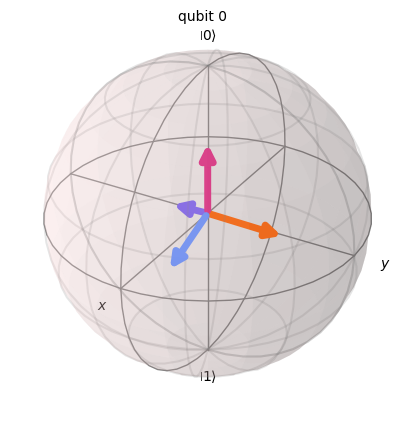

In [2]:
import numpy as np
from povm_toolbox.library import DilationMeasurements

# parameters that define a SIC-POVM (SIC stands for "symmetric and informationally-complete")
sic_parameters = np.array(
    [0.75, 0.30408673, 0.375, 0.40678524, 0.32509973, 0.25000035, 0.49999321, 0.83333313],
)

povm = DilationMeasurements(num_qubits=1, parameters=sic_parameters)
povm.definition().draw_bloch()

For dilation measurements, each qubit to be measured is associated with an ancilla qubit. Then, a two-qubit gate is applied and measurements in the computational basis are performed. The binary outcomes of the system qubit and the ancilla qubit are combined to generate a single POVM outcome (in the set `{0,1,2,3}`).

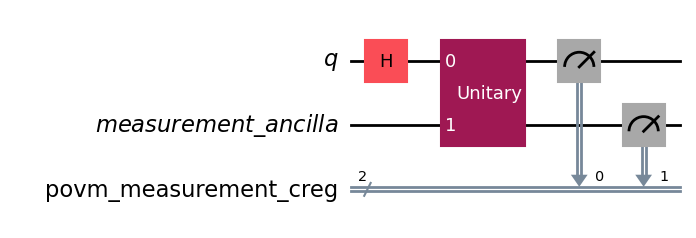

In [3]:
from qiskit.circuit import QuantumCircuit

qc = QuantumCircuit(1)
qc.h(0)

povm.compose_circuits(qc).draw("mpl")

## Adding necessary ancilla qubits

The user doesn't have to deal with adding ancilla qubits, the method `DilationMeasurements.compose_circuit` takes care of adding ancilla qubits when necessary. It will check if the input circuit has idling qubits that can used. If there is not enough idling qubits in the input circuit, the method will add additional ancilla qubits to the input circuit.

### 1. Quantum Circuit without ancilla qubits

Example of a quantum circuit without idling qubits.

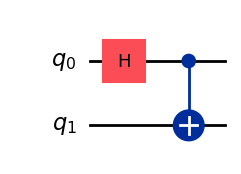

In [4]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

qc.draw("mpl")

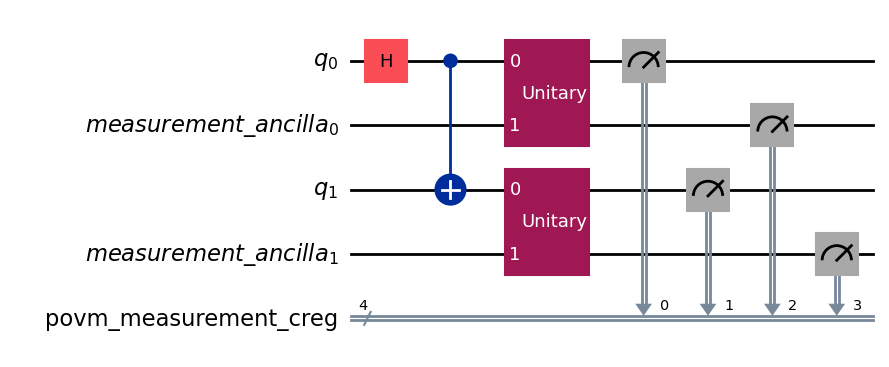

In [5]:
povm = DilationMeasurements(num_qubits=2, parameters=sic_parameters)

# The input circuit does not have any idling qubits. The method `compose_circuit` will add two ancilla qubits.
povm.compose_circuits(qc).draw("mpl", wire_order=[0, 2, 1, 3])

### 2. Quantum Circuit with a few idling qubits

Example of a quantum circuit with a few idling qubits, but not enough.

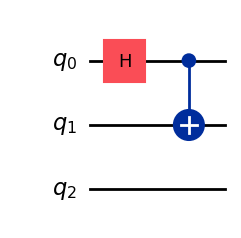

In [6]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)

qc.draw("mpl")

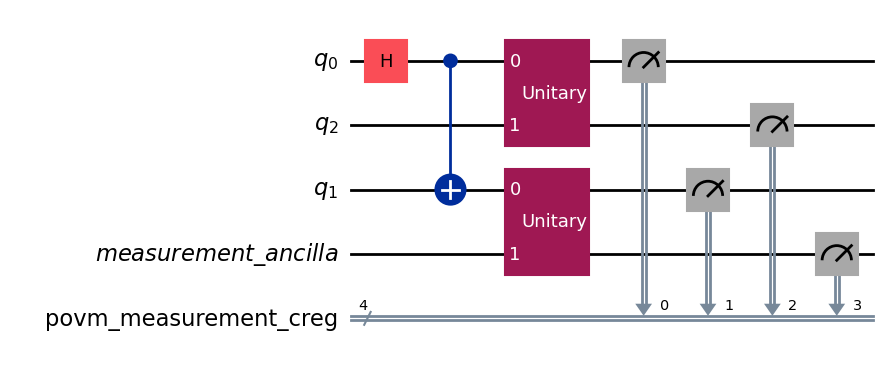

In [7]:
povm.measurement_layout = [0, 1]

# The input circuit has one idling qubit. The method `compose_circuit` will use it and also add one ancilla qubit.
povm.compose_circuits(qc).draw("mpl", wire_order=[0, 2, 1, 3])

### 3. Quantum Circuit with enough idling qubits

Example of a quantum circuit with a few idling qubits, but not enough.

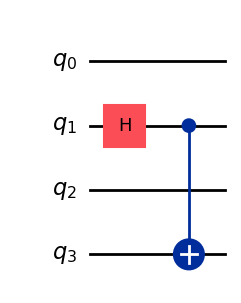

In [8]:
qc = QuantumCircuit(4)
qc.h(1)
qc.cx(1, 3)


qc.draw("mpl")

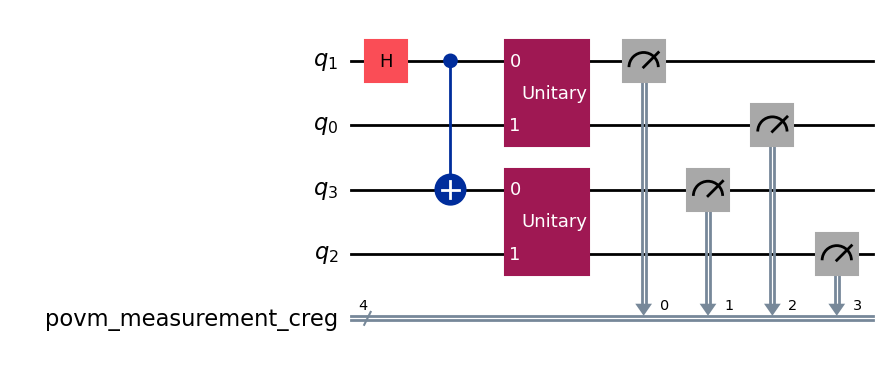

In [9]:
povm.measurement_layout = [1, 3]

# The input circuit has two idling qubit. The method `compose_circuit` will use both of them and does not need to add any additional ancilla qubits.
povm.compose_circuits(qc).draw("mpl", wire_order=[1, 0, 3, 2])

### 4. Quantum Circuit with many idling qubits

Example of a quantum circuit with more than enough idling qubits.

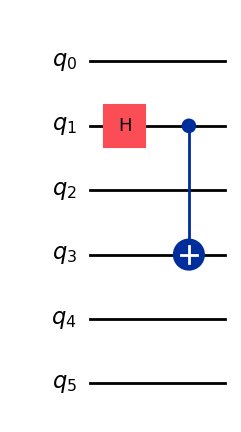

In [10]:
qc = QuantumCircuit(6)
qc.h(1)
qc.cx(1, 3)

qc.draw("mpl")

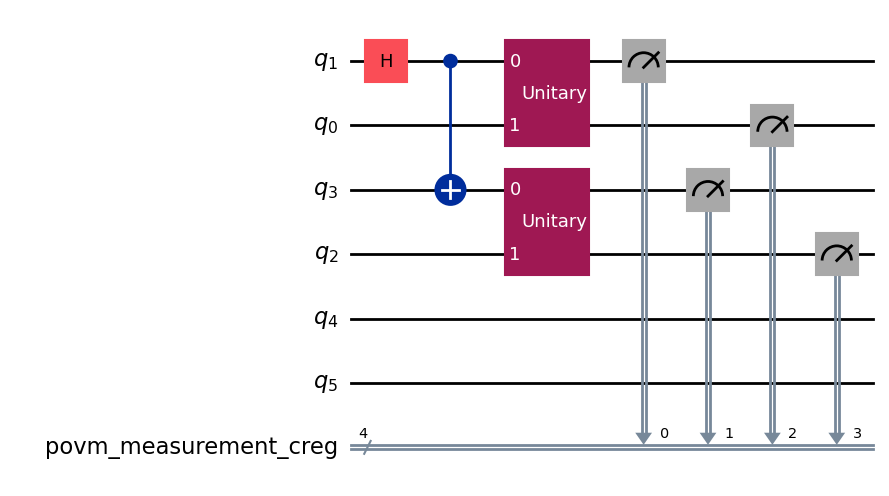

In [11]:
povm.measurement_layout = [1, 3]

# The input circuit has four idling qubit. The method `compose_circuit` will use two of them (and does not need to add any additional ancilla qubits).
povm.compose_circuits(qc).draw("mpl", wire_order=[1, 0, 3, 2, 4, 5])

### 5. Quantum circuit with ancilla qubits that are not idling

Example of a quantum circuit that has

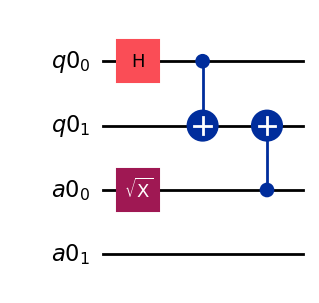

In [12]:
from qiskit.circuit import AncillaRegister, QuantumRegister

qc = QuantumCircuit(QuantumRegister(2), AncillaRegister(2))
qc.h(0)
qc.cx(0, 1)
qc.sx(2)
qc.cx(2, 1)

qc.draw("mpl")

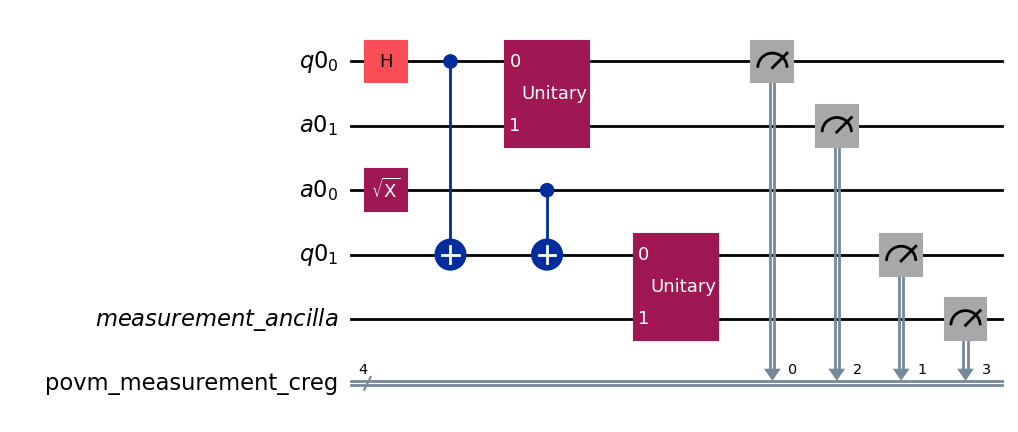

In [13]:
# We only want to measure qubits 0 and 1 (qubit 2 is an ancilla qubit)
povm.measurement_layout = [0, 1]

# The input circuit has one idling qubit. The method `compose_circuit` will use it and also add one ancilla qubit.
povm.compose_circuits(qc).draw("mpl", wire_order=[0, 3, 2, 1, 4])

## Transpiled Quantum Circuits

Examples with transpiled quantum circuits.

### Generate a generic backend

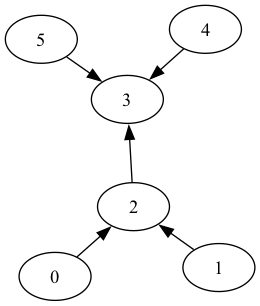

In [14]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Generate a 6-qubit simulated backend
backend = GenericBackendV2(num_qubits=6, coupling_map=[[0, 2], [1, 2], [2, 3], [4, 3], [5, 3]])

backend.set_options(seed_simulator=25)
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)

coupling_map = backend.coupling_map
# coupling_map.draw()

### Define quantum circuit

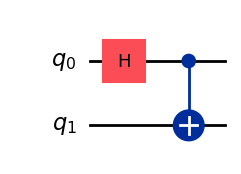

In [15]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw("mpl")

### Transpile circuit

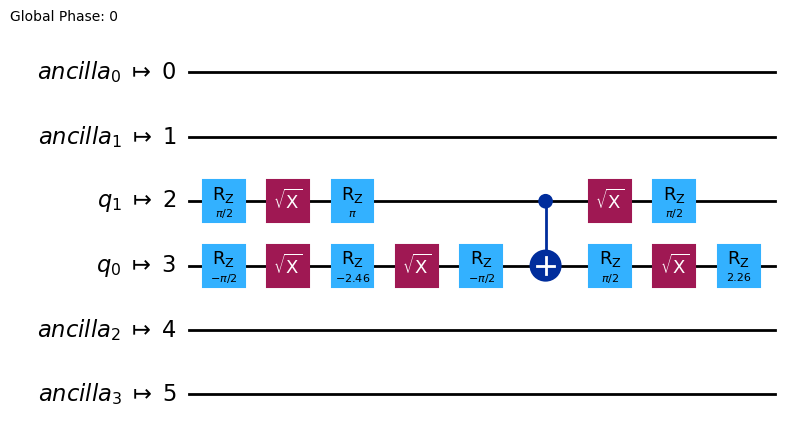

In [16]:
# Transpile the circuit to an "Instruction Set Architecture" (ISA) circuit.
# Note: the transpiler automatically adds "ancilla" qubits to make the transpiled
# circuit match the size of the backend.
qc_isa = pm.run(qc)
qc_isa.draw("mpl", style="iqp")

### Define measurement procedure

No need to set a particular `measurement_layout`, because the `POVMSampler` will analyze the transpiled circuit and apply the `TranspileLayout` to the measurement circuit.

In [17]:
measurement = DilationMeasurements(
    num_qubits=2,
    parameters=sic_parameters,
)

More precisely, the measurement layout that will be automatically applied by the `POVMSampler` is extracted as :
```python
transpile_layout = transpiled_circuit.layout
measurement_layout = transpile_layout.final_index_layout(filter_ancillas=True)
```
For the above circuit, we have:

In [18]:
print(qc_isa.layout.final_index_layout(filter_ancillas=True))

[3, 2]


### Run the job

Initialize `Sampler` and `POVMSampler`. Then run the job. A pass manager has to be provided to transform the final composed circuit into an ISA circuit.

In [19]:
from povm_toolbox.sampler import POVMSampler
from qiskit_ibm_runtime import SamplerV2 as RuntimeSampler

# First define a standard sampler (that will be used under the hood).
runtime_sampler = RuntimeSampler(mode=backend)
# Then define the POVM sampler, which takes BaseSampler as an argument.
povm_sampler = POVMSampler(runtime_sampler)
# Submit the job by specifying which POVM to use, which circuit(s) to measure and the shot budget.
# A pass manager has to be provided to make the measurement circuit ISA.
job = povm_sampler.run([qc_isa], shots=4096, povm=measurement, pass_manager=pm)

Look at the final composed circuit to check that the measurement was performed on the correct qubits.

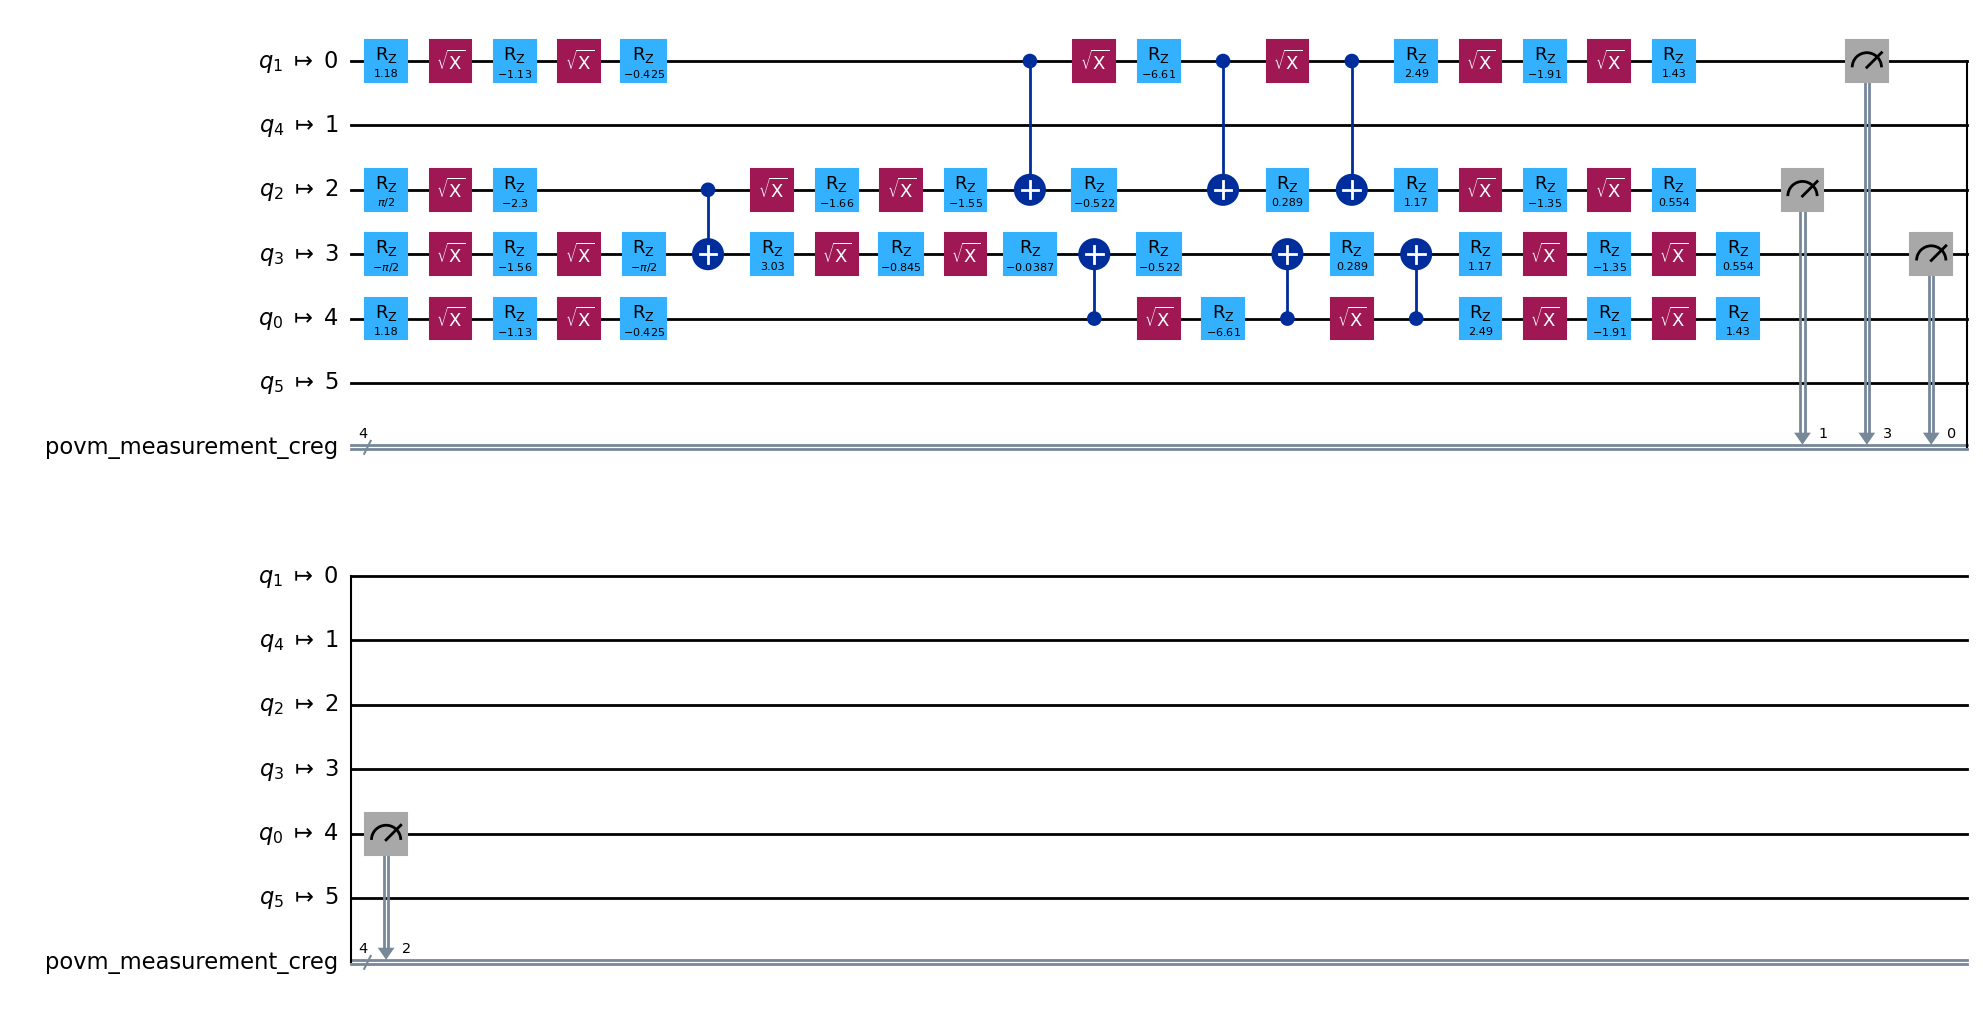

In [20]:
pub_result = job.result()[0]
pub_result.metadata.composed_circuit.draw("mpl", style="iqp")

### Define observable

In [21]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["XI", "XX", "YY", "ZX"], coeffs=[1, 1, -1, 1])

### Get the expected value

The observable has to be specified in terms of virtual qubits. Therefore, there is no need to apply the layout that was used by the POVM on the physical qubits.

In [22]:
from povm_toolbox.post_processor import POVMPostProcessor

post_processor = POVMPostProcessor(pub_result)
exp_value, std = post_processor.get_expectation_value(observable)
print(exp_value)

1.8636925066855423


For reference, we can compare our estimated expectation value to the exact value.


In [23]:
from qiskit.quantum_info import Statevector

isa_observable = observable.apply_layout(layout=qc_isa.layout, num_qubits=qc_isa.num_qubits)

exact_expectation_value = np.real_if_close(Statevector(qc_isa).expectation_value(isa_observable))
print(f"Exact value:     {exact_expectation_value}")
print(f"Estimated value: {exp_value}")

Exact value:     1.999999999999999
Estimated value: 1.8636925066855423


## Transpiled Quantum Circuit with ancilla qubits

Example where the quantum circuit had ancilla qubits before transpilation.

### Define quantum circuit
The circuit can contain some ancilla qubits that you might not want to measure.

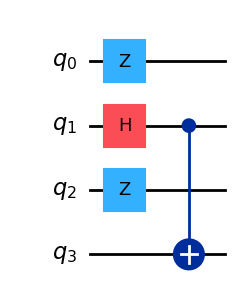

In [24]:
qc_with_ancilla = QuantumCircuit(4)

# Qubits (1,3):
qc_with_ancilla.h(1)
qc_with_ancilla.cx(1, 3)

# Ancilla qubits (0,2):
qc_with_ancilla.z(0)
qc_with_ancilla.z(2)

qc_with_ancilla.draw("mpl", style="iqp")

### Transpile circuit with ancilla qubits

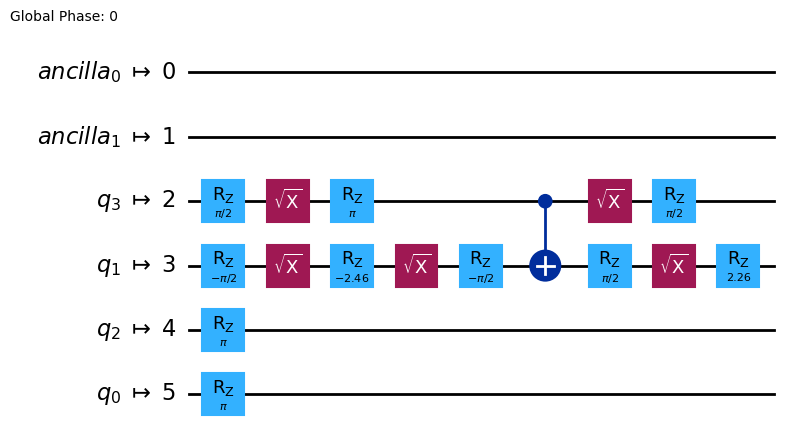

In [25]:
# Transpile the circuit to an "Instruction Set Architecture" (ISA) circuit
qc_with_ancilla_isa = pm.run(qc_with_ancilla)
qc_with_ancilla_isa.draw("mpl", style="iqp")

### Define measurement procedure

The `measurement_layout` argument specifies which qubits to measure. This argument overrides the automatic detection of a possible `TranspileLayout` attribute of the supplied circuit. I.e., it specifies directly the (final) physical qubits on which the POVM will act. In this example, we want to measure physical qubits 4 and 3.

If you want to specify the virtual qubits instead (here virtual qubits 1 and 3), you have to do the composition with the `TranspileLayout` manually as follows:

In [26]:
# Measuring virtual qubits 1 and 3
virtual_msmt_layout = [1, 3]
# Get the transpilation layout
transpile_layout = qc_with_ancilla_isa.layout.final_index_layout()
# Compute the final measurement layout
final_msmt_layout = [transpile_layout[idx] for idx in virtual_msmt_layout]
print("Final measurement layout:", final_msmt_layout)

measurement = DilationMeasurements(
    2,
    measurement_layout=final_msmt_layout,
    parameters=sic_parameters,
)

Final measurement layout: [3, 2]


### Run the job

Initialize `Sampler` and `POVMSampler`. Then run the job.

In [27]:
# First define a standard sampler (that will be used under the hood).
runtime_sampler = RuntimeSampler(mode=backend)
# Then define the POVM sampler, which takes BaseSampler as an argument.
povm_sampler = POVMSampler(runtime_sampler)
# Submit the job by specifying which POVM to use, which circuit(s) to measure and the shot budget.
job = povm_sampler.run([qc_with_ancilla_isa], shots=4096, povm=measurement, pass_manager=pm)
pub_result = job.result()[0]

You can check that measurement was performed on the correct physical qubits by looking at the final composed circuit.

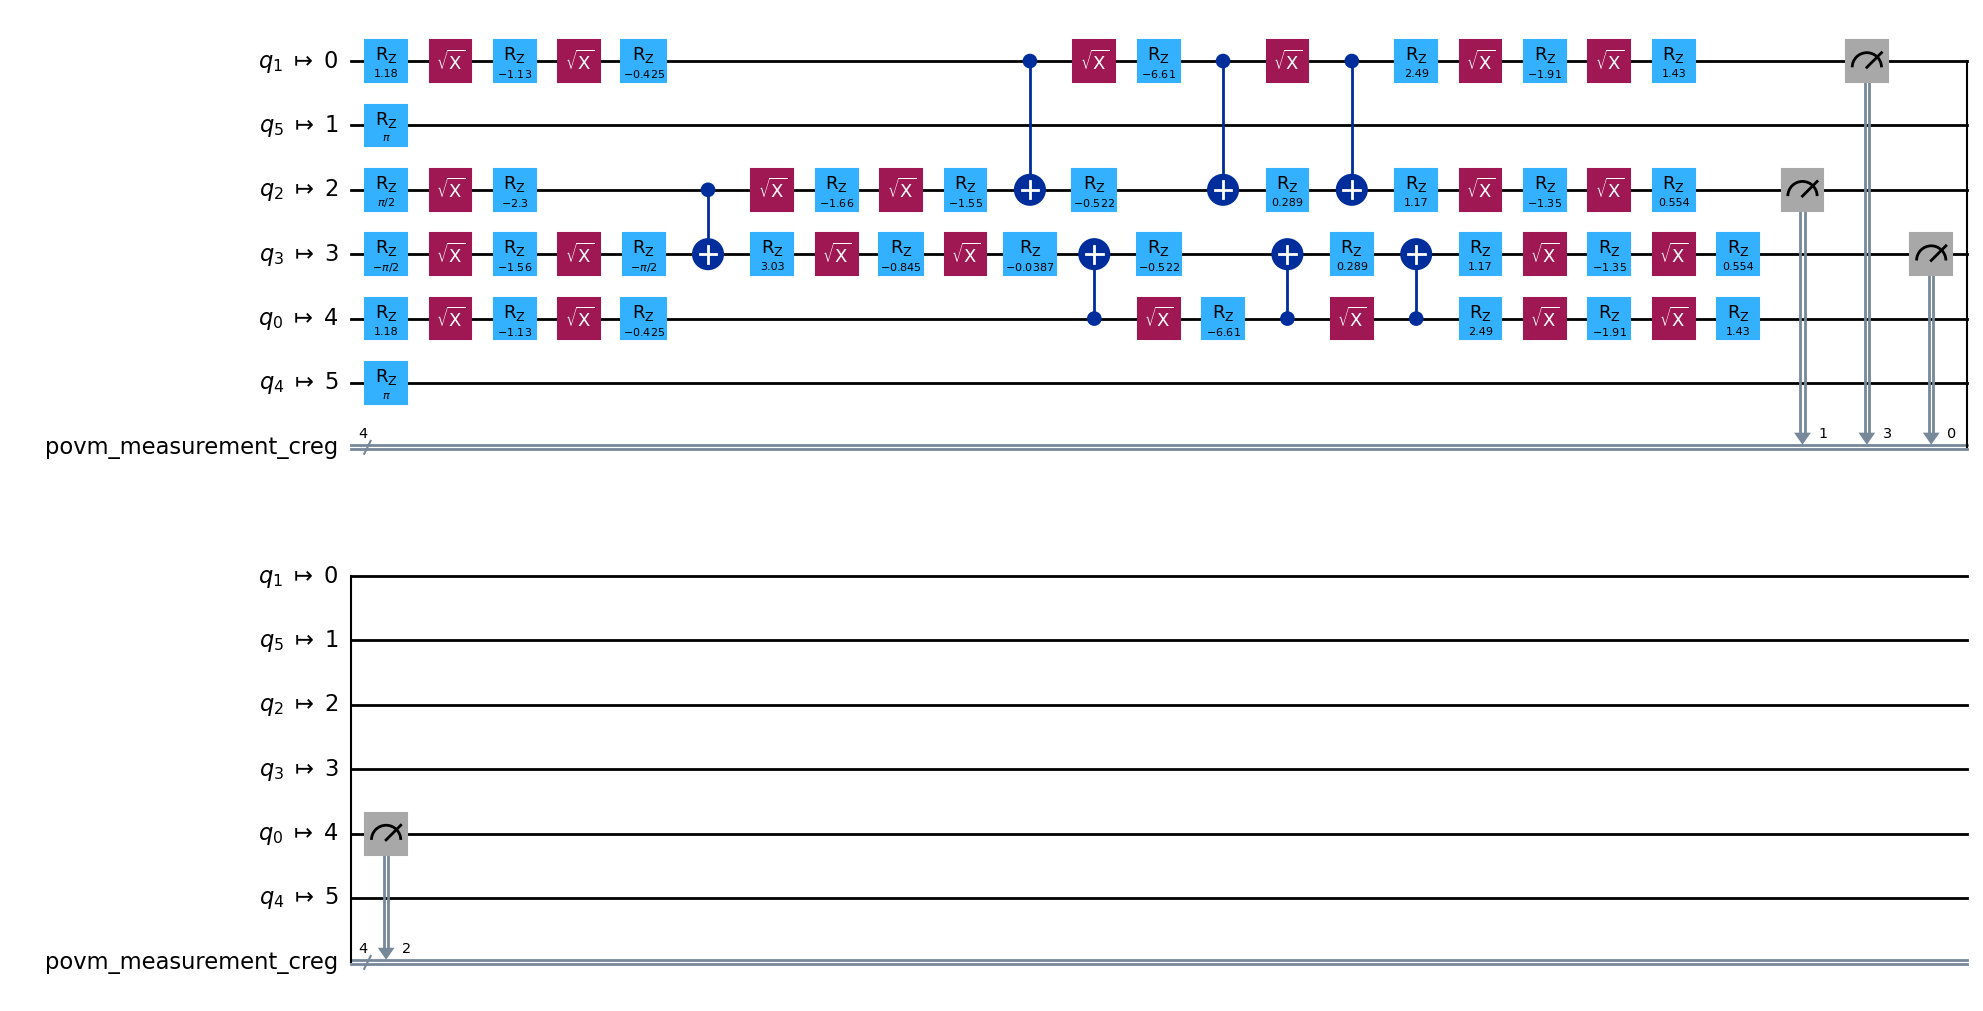

In [28]:
pub_result.metadata.composed_circuit.draw("mpl", style="iqp")

### Get the expected value

The observable has to be specified in terms of virtual qubits. Therefore, there is no need to apply the layout that was used by the POVM on the physical qubits.

In [29]:
post_processor = POVMPostProcessor(pub_result)

print(f"Exact value:     {exact_expectation_value}")

exp_value, std = post_processor.get_expectation_value(observable)
print(f"Estimated value: {exp_value}")

Exact value:     1.999999999999999
Estimated value: 1.8636925066855423
